![image](images/photo.jpg)

# HOUSE PRICES
# PART 3 - CLASSIFICATION

---
### Table of contents
1. [INTRODUCTION](#1.-INTRODUCTION) <br>
1.1 [Problem description](#1.1-Problem-description) <br>
1.2 [Python libraries](#1.2-Python-libraries) <br>
1.3 [Import transformed dataset](#1.3-Import-transformed-dataset) <br>
2. [DATASET SPLITTING](#2.-DATASET-SPLITTING) <br>
3. [MACHINE LEARNING MODELS](#2.-MACHINE-LEARNING-MODELS) <br>
3.1 [Decision Tree](#3.1-Decision-Tree) <br>
3.2 [Random Forest](#3.2-Random-Forest) <br>
3.3 [Logistic Regression](#3.3-Logistic-Regression) <br>
3.4 [Support Vector Machine](#3.4-Support-Vector-Machine) <br>
3.5 [K-nearest Neighbors Vote](#3.5-K-nearest-Neighbors-Vote) <br>
3.6 [XGBoost Classifier](#3.6-XGBoost-Classifier) <br>
4. [MODELS EVALUATION](#4.-MODELS-EVALUATION) <br>
5. [BEST MODEL SELECTION](#5.-BEST-MODEL-SELECTION) <br>

---
# 1. INTRODUCTION
## 1.1 Problem description 
The aim of the study is to build a classification model predicting if a house is worth above or below 600,000$ based on its characteristics. Several ML techniques were tested for this purpose.

## 1.2 Python libraries

In [2]:
# Data analysis, processing and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Display settings
pd.set_option('display.max_columns', 30)
pd.options.display.float_format = '{:.2f}'.format

# Machine Learning
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

## 1.3 Import transformed dataset

In [3]:
df = pd.read_csv("data/kc_house_data_transformed.csv")
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,sales_year,sales_month,property_age,renovated_bin,view_0,view_1,view_2,view_3,view_4,price_bin
0,12.31,1.80,1.00,7.82,4.32,1.00,0,1.57,7,3.36,0.00,98178,47.51,-122.26,3.47,4.16,2014,10,59,0,1,0,0,0,0,0.00
1,13.20,1.80,2.25,8.78,4.37,2.00,0,1.57,7,3.47,69.34,98125,47.72,-122.32,3.51,4.22,2014,12,63,1,1,0,0,0,0,0.00
2,12.10,1.35,1.00,7.30,4.43,1.00,0,1.57,6,3.29,0.00,98028,47.74,-122.23,3.59,4.23,2015,2,82,0,1,0,0,0,0,0.00
3,13.31,2.18,3.00,8.44,4.29,1.00,0,2.11,7,3.34,117.87,98136,47.52,-122.39,3.47,4.14,2014,12,49,0,1,0,0,0,0,1.00
4,13.14,1.80,2.00,8.25,4.39,1.00,0,1.57,8,3.42,0.00,98074,47.62,-122.05,3.52,4.21,2015,2,28,0,1,0,0,0,0,0.00


---
# 2. DATASET SPLITTING
The data set was divided into 2 parts:
- training set (66% of observations),
- test set (33% of observations).

The process of learning and selecting parameters for individual models (using cross-validation) will be carried out on the training set. The test set will be used for the final models evaluation and selection of the best model.

In [5]:
X = df.drop(["price", "price_bin"] , axis = 1)
y = df["price_bin"]
print("Dataframes shapes before splitting data:", X.shape, y.shape)

Dataframes shapes before splitting data: (21613, 24) (21613,)


In [6]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)
print("Train set - dataframes shapes:", X_train.shape, y_train.shape)
print("Test set - dataframes shapes:", X_test.shape, y_test.shape)

Train set - dataframes shapes: (14480, 24) (14480,)
Test set - dataframes shapes: (7133, 24) (7133,)


The chart below shows the numbers of observations in groups for the training set and test sets.

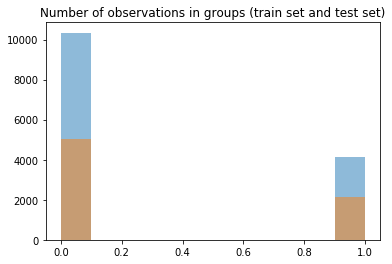

In [7]:
plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.title('Number of observations in groups (train set and test set)')
plt.show()

---
# 3. MACHINE LEARNING MODELS
The study uses 6 types of ML models for classification:

- Decision Tree
- Random Forest
- Logistic Regression
- Support Vector Machine
- K-nearest Neighbors Vote
- XGBoost Classifier

Standardization was applied before learning process of some models. <br>
All models were tested on various combinations of parameters using GridSearchCV.

In [9]:
# Function for model evaluation
def evaluate_class_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    y_pred_train = model.predict(X_train)
    print("Classification report - train set :\n{}".format(classification_report(y_train, y_pred_train)))
    print('******************************************************')
    y_pred_test = model.predict(X_test)
    print("Classification report - test set :\n{}".format(classification_report(y_test, y_pred_test)))

In [10]:
# Setup cross validation folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

## 3.1 Decision Tree
Decision tree classifier.
Parameters tested:
- **criterion** - the function to measure the quality of a split. “Gini” for the Gini impurity and “entropy” for the information gain.
- **max_depth** - the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- **max_leaf_nodes** - grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

In [12]:
# Decision Tree Classifier
model0 = DecisionTreeClassifier()
grid_param0 = {"criterion" : ["gini", "entropy"],
               "max_depth" : [None, 3, 4, 5, 10, 15, 50],
               "max_leaf_nodes" : [None, 10, 20, 50, 100, 200]}

grid_obj0 = GridSearchCV(model0, grid_param0, cv=kfold, refit=True)
grid_obj0.fit(X_train, y_train)

# Results
print("Best parameters:\n{}".format(grid_obj0.best_params_))
print("Best score accuracy:\n{}".format(grid_obj0.best_score_))
print('******************************************************')
evaluate_class_model(grid_obj0.best_estimator_)

Best parameters:
{'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 100}
Best score accuracy:
0.9008977900552486
******************************************************
Classification report - train set :
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     10340
         1.0       0.90      0.84      0.87      4140

    accuracy                           0.93     14480
   macro avg       0.92      0.90      0.91     14480
weighted avg       0.93      0.93      0.93     14480

******************************************************
Classification report - test set :
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94      5017
         1.0       0.87      0.81      0.84      2116

    accuracy                           0.91      7133
   macro avg       0.90      0.88      0.89      7133
weighted avg       0.91      0.91      0.91      7133



#### Model evaluation
For model evaluation, the following metrics have been used:
- **Accuracy** - the sum of true positives and true negatives divided by the total number of samples.
- **Precision** - quantifies the number of positive class predictions that actually belong to the positive class.
- **Recall** - quantifies the number of positive class predictions made out of all positive examples in the dataset.
- **F1 score** - weighted average between precision and recall.

#### Results for test set:
- accuracy: 91%
- precision: 87%
- recall: 81%
- F1 Score: 84%

#### Tree visualization

/Users/kingamianowana/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


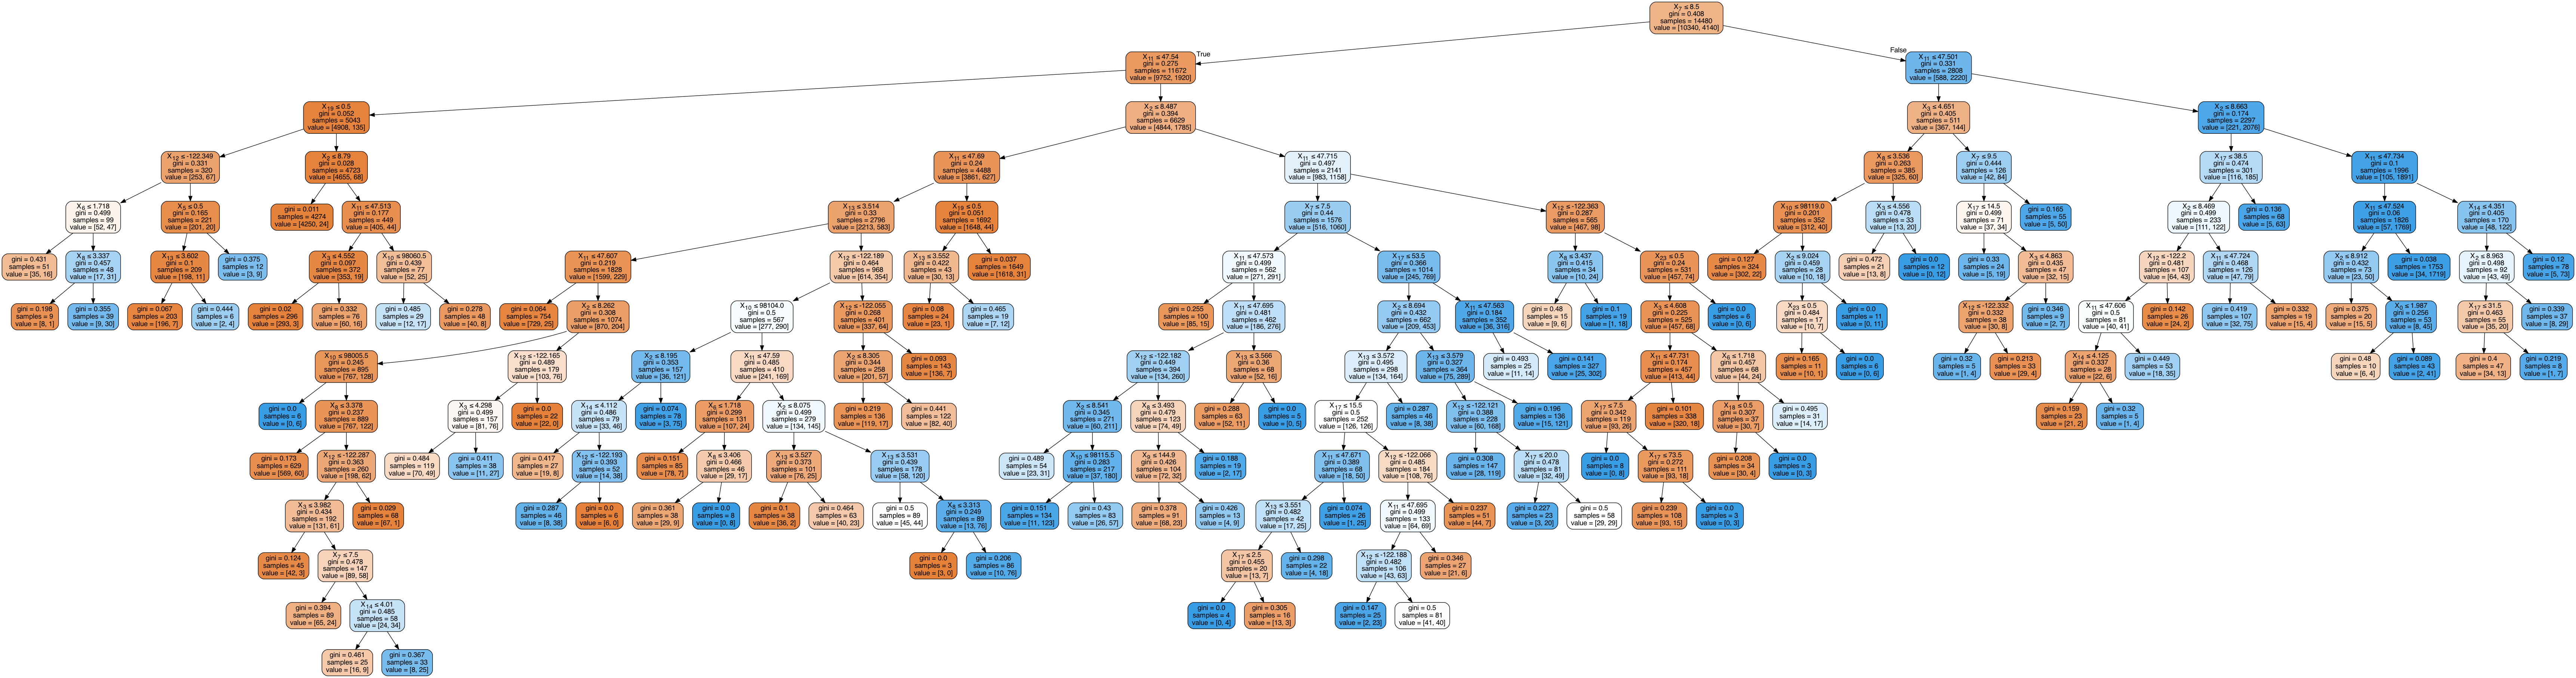

In [13]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# Display decisin tree
dot_data = StringIO()
export_graphviz(grid_obj0.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Feature importance
The importance of a feature for Decision Tree is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance. <br>
As you can se from the plot below, the most important features in the model are: **"grade", "lat", sqft_living"** - together **0.84** of normalized total  reduction of criteria by features.

In [14]:
# Function for feature importance graph
def plot_feature_importances(model, data):
    feature_names = data.columns.values  
    df_featimport = pd.DataFrame([i for i in zip(feature_names, model.feature_importances_)],   
                                 columns=["features","importance"])
    plot = sns.barplot(x="importance", y="features",   
                       data=df_featimport.sort_values('importance', ascending=False))  
    plot.set(xlabel='Feature Importance')  
    plot.set(ylabel='Feature')

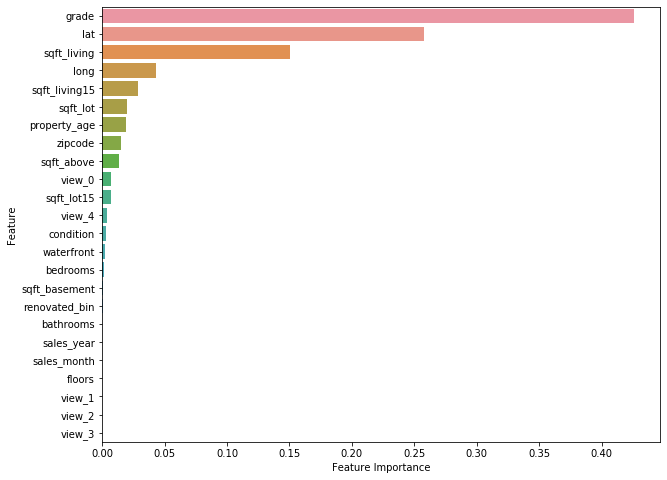

In [15]:
# Decision Tree Classifier - feature importance
plt.figure(figsize=(10, 8))
plot_feature_importances(grid_obj0.best_estimator_, X_train) 

## 3.2 Random Forest

Random forest classifier. Parameters tested:
- **max_depth** -the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- **max_leaf_nodes** - grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
- **bootstrap** - whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
- **max_features** - the number of features to consider when looking for the best split.

In [16]:
# Random Forest Classifier
model1 = RandomForestClassifier(n_estimators=100)
grid_param1 = {"max_depth" : [5, 10, 15, 20],
               "max_leaf_nodes" : [10, 20, 50, 100, 150],
               "bootstrap" : [True, False],
               "max_features" : ["auto", "sqrt", "log2"]}

grid_obj1 = GridSearchCV(model1, grid_param1, cv=kfold, refit=True)
grid_obj1.fit(X_train, y_train)

# Results
print("Best parameters:\n{}".format(grid_obj1.best_params_))
print("Best score accuracy:\n{}".format(grid_obj1.best_score_))
print('******************************************************')
evaluate_class_model(grid_obj1.best_estimator_)

Best parameters:
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 150}
Best score accuracy:
0.9119475138121548
******************************************************
Classification report - train set :
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     10340
         1.0       0.93      0.85      0.89      4140

    accuracy                           0.94     14480
   macro avg       0.94      0.91      0.92     14480
weighted avg       0.94      0.94      0.94     14480

******************************************************
Classification report - test set :
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      5017
         1.0       0.90      0.81      0.85      2116

    accuracy                           0.92      7133
   macro avg       0.91      0.89      0.90      7133
weighted avg       0.92      0.92      0.92      7133



#### Model evaluation
For model evaluation, the following metrics have been used:
- **Accuracy** - the sum of true positives and true negatives divided by the total number of samples.
- **Precision** - quantifies the number of positive class predictions that actually belong to the positive class.
- **Recall** - quantifies the number of positive class predictions made out of all positive examples in the dataset.
- **F1 score** - weighted average between precision and recall.

#### Results for test set:
- accuracy: 92%
- precision: 90%
- recall: 81%
- F1 Score: 85%

#### Feature importance
The importance of a feature for Random Forest is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance. <br>
The most important features in the model are: **"lat", "sqft_living", grade"** - together **0.53** of normalized total  reduction of criteria by features.

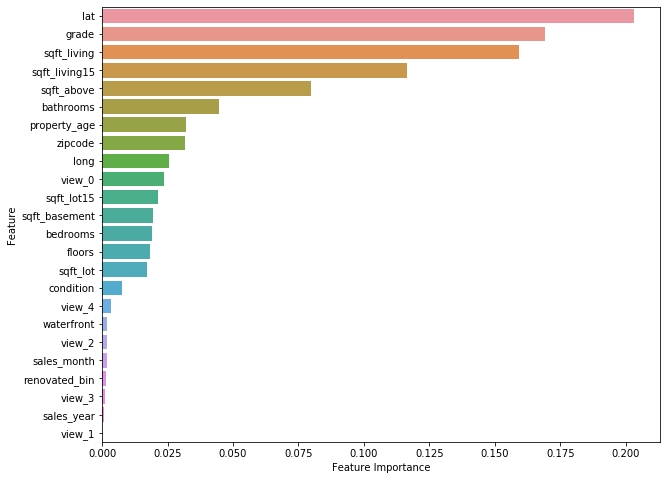

In [17]:
# Random Forest Classifier - feature importance
plt.figure(figsize=(10, 8))
plot_feature_importances(grid_obj1.best_estimator_, X_train) 

## 3.3 Logistic Regression
Logistic regression. Before applying ML technique, standardization was performed. Parameters tested:
- **penalty** - to specify the norm used in the penalization.
- **C** - inverse of regularization strength, smaller values specify stronger regularization.

In [18]:
# Logistic Regression
model2 = Pipeline([("standardization", StandardScaler()),
                   ("logit", LogisticRegression(solver="liblinear"))])
grid_param2 = {"logit__penalty": ["l1", "l2"],
               "logit__C": [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 200, 300, 400]}
grid_obj2 = GridSearchCV(model2, grid_param2, cv=kfold, refit=True)
grid_obj2.fit(X_train, y_train)

# Results
print("Best parameters:\n{}".format(grid_obj2.best_params_))
print("Best score accuracy:\n{}".format(grid_obj2.best_score_))
print('******************************************************')
evaluate_class_model(grid_obj2.best_estimator_)

Best parameters:
{'logit__C': 1, 'logit__penalty': 'l2'}
Best score accuracy:
0.8746546961325967
******************************************************
Classification report - train set :
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.91     10340
         1.0       0.82      0.73      0.77      4140

    accuracy                           0.88     14480
   macro avg       0.86      0.83      0.84     14480
weighted avg       0.87      0.88      0.87     14480

******************************************************
Classification report - test set :
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92      5017
         1.0       0.84      0.74      0.79      2116

    accuracy                           0.88      7133
   macro avg       0.87      0.84      0.85      7133
weighted avg       0.88      0.88      0.88      7133



#### Model evaluation
For model evaluation, the following metrics have been used:
- **Accuracy** - the sum of true positives and true negatives divided by the total number of samples.
- **Precision** - quantifies the number of positive class predictions that actually belong to the positive class.
- **Recall** - quantifies the number of positive class predictions made out of all positive examples in the dataset.
- **F1 score** - weighted average between precision and recall.

#### Results for test set:
- accuracy: 88%
- precision: 84%
- recall: 74%
- F1 Score: 79%

## 3.4 Support Vector Machine
Support Vector Machine. Before applying ML technique, standardization was performed. Parameters tested:
- **kernel** -  the kernel type to be used in the algorithm. 
- **degree** - degree of the polynomial kernel function.
- **gamma** - kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
- **C** -  regularization parameter. The strength of the regularization is inversely proportional to C.

SVM is very **sensitive to the parameters used during learning process.** For this reason, the learning process was carried out twice. <br>
During the first run, a wide range of parameters were used (different kernel types, different degrees of polynomial kernel function, etc.). During the second run, the number of tested values of numerical parameters was increased (regularization parameter, kernel coefficient).

In [19]:
# SVM
model3 = Pipeline([("standardization", StandardScaler()),
                   ("svc", SVC(probability=True))])
grid_param3 = [{"svc__kernel":["poly"], "svc__degree":[2,3,4,5], "svc__C": [0.1, 1, 10, 100]},
               {"svc__kernel":["rbf"], "svc__gamma":[0.1,1,10], "svc__C": [0.1, 1, 10, 100]},
               {"svc__kernel":["linear", "sigmoid"], "svc__C": [0.1, 1, 10, 100]}]
grid_obj3 = GridSearchCV(model3, grid_param3, cv=kfold, refit=True)
grid_obj3.fit(X_train, y_train)

# Results
print("Best parameters:\n{}".format(grid_obj3.best_params_))
print("Best score accuracy:\n{}".format(grid_obj3.best_score_))

Best parameters:
{'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best score accuracy:
0.9004834254143645


In [20]:
# SVM
model3 = Pipeline([("standardization", StandardScaler()),
                   ("svc", SVC(kernel = "rbf", probability=True))])
grid_param3 = {"svc__gamma":[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
               "svc__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
grid_obj3 = GridSearchCV(model3, grid_param3, cv=kfold, refit=True)
grid_obj3.fit(X_train, y_train)

# Results
print("Best parameters:\n{}".format(grid_obj3.best_params_))
print("Best score accuracy:\n{}".format(grid_obj3.best_score_))
print('******************************************************')
evaluate_class_model(grid_obj3.best_estimator_)

Best parameters:
{'svc__C': 100000, 'svc__gamma': 0.001}
Best score accuracy:
0.9073895027624308
******************************************************
Classification report - train set :
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95     10340
         1.0       0.91      0.86      0.88      4140

    accuracy                           0.93     14480
   macro avg       0.93      0.91      0.92     14480
weighted avg       0.93      0.93      0.93     14480

******************************************************
Classification report - test set :
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      5017
         1.0       0.88      0.82      0.85      2116

    accuracy                           0.91      7133
   macro avg       0.90      0.89      0.90      7133
weighted avg       0.91      0.91      0.91      7133



#### Model evaluation
For model evaluation, the following metrics have been used:
- **Accuracy** - the sum of true positives and true negatives divided by the total number of samples.
- **Precision** - quantifies the number of positive class predictions that actually belong to the positive class.
- **Recall** - quantifies the number of positive class predictions made out of all positive examples in the dataset.
- **F1 score** - weighted average between precision and recall.

#### Results for test set:
- accuracy: 91%
- precision: 88%
- recall: 82%
- F1 Score: 85%

## 3.5 K-nearest Neighbors Vote
Classifier implementing the k-nearest neighbors vote. Before applying ML technique, standardization was performed. Parameters tested:
- **n_neighbors** - number of neighbors to use by default for kneighbors queries.
- **weights** - weight function used in prediction.

In [21]:
# KNeighborsClassifier
model4 = Pipeline([("standardization", StandardScaler()),
                   ("kn", KNeighborsClassifier())])
grid_param4 = {'kn__n_neighbors': list(range(1,15)), 
               'kn__weights': ['uniform', 'distance']}
grid_obj4 = GridSearchCV(model4, grid_param4, cv=kfold, refit=True)
grid_obj4.fit(X_train, y_train)

# Results
print("Best parameters:\n{}".format(grid_obj4.best_params_))
print("Best score accuracy:\n{}".format(grid_obj4.best_score_))
print('******************************************************')
evaluate_class_model(grid_obj4.best_estimator_)

Best parameters:
{'kn__n_neighbors': 11, 'kn__weights': 'distance'}
Best score accuracy:
0.887914364640884
******************************************************
Classification report - train set :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10340
         1.0       1.00      1.00      1.00      4140

    accuracy                           1.00     14480
   macro avg       1.00      1.00      1.00     14480
weighted avg       1.00      1.00      1.00     14480

******************************************************
Classification report - test set :
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93      5017
         1.0       0.85      0.78      0.81      2116

    accuracy                           0.89      7133
   macro avg       0.88      0.86      0.87      7133
weighted avg       0.89      0.89      0.89      7133



#### Model evaluation
For model evaluation, the following metrics have been used:
- **Accuracy** - the sum of true positives and true negatives divided by the total number of samples.
- **Precision** - quantifies the number of positive class predictions that actually belong to the positive class.
- **Recall** - quantifies the number of positive class predictions made out of all positive examples in the dataset.
- **F1 score** - weighted average between precision and recall.

#### Results for test set:
- accuracy: 89%
- precision: 85%
- recall: 78%
- F1 Score: 81%

## 3.6 XGBoost Classifier
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.
Parameters tested:
- **max_depth** - maximum tree depth for base learners.
- **learning_rate** – boosting learning rate
- **gamma** - minimum loss reduction required to make a further partition on a leaf node of the tree.
- **colsample_bytree** - subsample ratio of columns when constructing each tree.
- **min_child_weight** - minimum sum of instance weight(hessian) needed in a child.

In [22]:
# XGBoost Classifier
model5 = XGBClassifier(n_estimators=50)
grid_param5 = {'max_depth': [3, 4, 5],
               'learning_rate': [0.1, 0.2, 0.5],
               'gamma': [0, 0.5, 1],
               'colsample_bytree': [1, 0.8, 0.5],
               'min_child_weight': [1, 5, 10]}

grid_obj5 = GridSearchCV(model5, grid_param5, cv=kfold, refit=True)
grid_obj5.fit(X_train, y_train)

# Results
print("Best parameters:\n{}".format(grid_obj5.best_params_))
print("Best score accuracy:\n{}".format(grid_obj5.best_score_))
print('******************************************************')
evaluate_class_model(grid_obj5.best_estimator_)

Best parameters:
{'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.5, 'max_depth': 4, 'min_child_weight': 10}
Best score accuracy:
0.9263812154696133
******************************************************
Classification report - train set :
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     10340
         1.0       0.92      0.90      0.91      4140

    accuracy                           0.95     14480
   macro avg       0.94      0.93      0.94     14480
weighted avg       0.95      0.95      0.95     14480

******************************************************
Classification report - test set :
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      5017
         1.0       0.89      0.87      0.88      2116

    accuracy                           0.93      7133
   macro avg       0.92      0.91      0.91      7133
weighted avg       0.93      0.93      0.93      7133



#### Model evaluation
For model evaluation, the following metrics have been used:
- **Accuracy** - the sum of true positives and true negatives divided by the total number of samples.
- **Precision** - quantifies the number of positive class predictions that actually belong to the positive class.
- **Recall** - quantifies the number of positive class predictions made out of all positive examples in the dataset.
- **F1 score** - weighted average between precision and recall.

#### Results for test set:
- accuracy: 93%
- precision: 89%
- recall: 87%
- F1 Score: 88%

#### Feature importance
Feature importances for XGBoost is shown on the plot below. <br>
The most important features in the model are: **"sqft_living15", "sqft_living", grade"** - together **0.42** of normalized total  reduction of criteria by features.

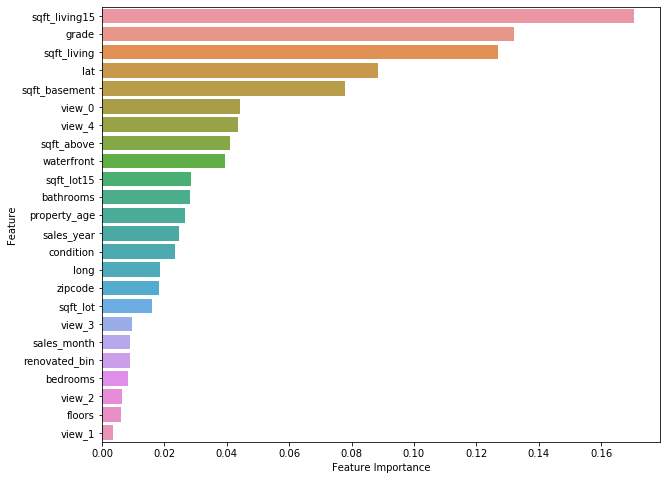

In [23]:
# XGBoost Classifier - feature importance
plt.figure(figsize=(10, 8))
plot_feature_importances(grid_obj5.best_estimator_, X_train) 

---
# 4. MODELS EVALUATION
In order to compare the models with each other and select the best one, a table was constructed containing the following measures:
- **Accuracy** - the sum of true positives and true negatives divided by the total number of samples.
- **Precision** - quantifies the number of positive class predictions that actually belong to the positive class.
- **Recall** - quantifies the number of positive class predictions made out of all positive examples in the dataset.
- **F1 score** - weighted average between precision and recall.
- **AUC** - area under the ROC curve

These measures were calculated for each model, both for the training set and the test set. The final model selection was based on the best results of the test set.

In [24]:
# Create list of models
models = []
models.append(('Decision Tree', grid_obj0.best_estimator_))
models.append(('Random Forest', grid_obj1.best_estimator_))
models.append(('Logistic Regression', grid_obj2.best_estimator_))
models.append(('SVM', grid_obj3.best_estimator_))
models.append(('KNeighbors Classifier', grid_obj4.best_estimator_))
models.append(('XGBoost Classifier', grid_obj5.best_estimator_))

# Create empty lists for measures
method = []
precision_score_train = []
recall_score_train = []
f1_score_train = []
accuracy_score_train = []
auc_score_train = []
precision_score_test = []
recall_score_test = []
f1_score_test = []
accuracy_score_test = []
auc_score_test = []

# Calculate measures
for name, model in models: 
    # method:
    method.append(name)
    # train set:
    y_pred_train = model.predict(X_train)
    precision_score_train.append(metrics.precision_score(y_train, y_pred_train))
    recall_score_train.append(metrics.recall_score(y_train, y_pred_train))
    f1_score_train.append(metrics.f1_score(y_train, y_pred_train))
    accuracy_score_train.append(metrics.accuracy_score(y_train, y_pred_train)) 
    auc_score_train.append(metrics.roc_auc_score(y_train, model.predict_proba(X_train)[:,1])) 
    # test set:
    y_pred_test = model.predict(X_test)
    precision_score_test.append(metrics.precision_score(y_test, y_pred_test))
    recall_score_test.append(metrics.recall_score(y_test, y_pred_test))
    f1_score_test.append(metrics.f1_score(y_test, y_pred_test))
    accuracy_score_test.append(metrics.accuracy_score(y_test, y_pred_test)) 
    auc_score_test.append(metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])) 

# Create table with matrices
d = {'Method' : method,
     'Precision (train)': precision_score_train, 
     'Recall (train)': recall_score_train, 
     'F1 (train)': f1_score_train,
     'Accuracy (train)' : accuracy_score_train,
     'AUC (train)' : auc_score_train,
     'Precision (test)': precision_score_test, 
     'Recall (test)': recall_score_test, 
     'F1 (test)': f1_score_test,
     'Accuracy (test)' : accuracy_score_test,
     'AUC (test)' : auc_score_test
    }
df_measures = pd.DataFrame(data=d)
df_measures

,Method,Precision (train),Recall (train),F1 (train),Accuracy (train),AUC (train),Precision (test),Recall (test),F1 (test),Accuracy (test),AUC (test)
0,Decision Tree,0.90,0.84,0.87,0.93,0.97,0.87,0.81,0.84,0.91,0.95
1,Random Forest,0.93,0.85,0.89,0.94,0.98,0.90,0.81,0.85,0.92,0.97
2,Logistic Regression,0.82,0.73,0.77,0.88,0.94,0.84,0.74,0.79,0.88,0.94
3,SVM,0.91,0.86,0.88,0.93,0.98,0.88,0.82,0.85,0.91,0.97
4,KNeighbors Classifier,1.00,1.00,1.00,1.00,1.00,0.85,0.78,0.81,0.89,0.95
5,XGBoost Classifier,0.92,0.90,0.91,0.95,0.99,0.89,0.87,0.88,0.93,0.98


---
# 5. BEST MODEL SELECTION

Among all tested techniques, **XGBoost Classifier** is the most effective. <br>
Accuracy (the sum of true positives and true negatives divided by the total number of samples) in class prediction is:
- for the training set - 0.95,
- for the test set - 0.93.

Moreover, all other measures work best with this technique as well.<br>
Comparing to the training set, the result is slightly worse on the test set. It's a natural situation. The difference is insignificant, which means that the model is **not overfitted**.